In [13]:

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from datasets import load_dataset
import torch
import torch.nn as nn
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer
import numpy as np
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve,auc
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from transformers import DistilBertModel, DistilBertConfig
from sklearn.metrics import classification_report


In [14]:
emotions = load_dataset('emotion')

emotions.set_format('pandas')
df = emotions['train'][:]
df.head()

def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

c:\Users\dianu\anaconda3\envs\torcher\lib\site-packages\datasets\load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [15]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


text_list_p=df["text"].tolist()
labels_p=df["label_name"].tolist()

text_list=[]
labels=[]
for i in range(len(labels_p)):
    if text_list_p[i]!='':
        text_list.append(text_list_p[i])
        labels.append(labels_p[i])

labels=np.array(labels)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
num_classes=int(np.max(integer_encoded)+1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
mapping = dict(zip(label_encoder.classes_, onehot_encoder.transform(label_encoder.transform(label_encoder.classes_).reshape(num_classes, 1))))
for key,value in mapping.items():
    print("",key," ----------------------------- ",value)



# randomly create indices for train and test
indices = np.arange(len(text_list))
np.random.shuffle(indices)
splitter=0.6
train_indices = indices[:int(splitter*len(text_list))]
test_indices = indices[int(splitter*len(text_list)):]
text_list_train = np.array(text_list)[train_indices]
text_list_test = np.array(text_list)[test_indices]
labels_train = np.array(labels)[train_indices]
labels_test = np.array(labels)[test_indices]
onehot_encoded_train = np.array(onehot_encoded)[train_indices]
onehot_encoded_test = np.array(onehot_encoded)[test_indices]
integer_encoded_train = np.array(integer_encoded)[train_indices]
integer_encoded_test = np.array(integer_encoded)[test_indices]


def custom_collate_fn(batch):
    input_ids, attention_mask, labels = zip(*batch)

    # Pad sequences so they are all the same length within a batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    labels = torch.stack(labels)

    return input_ids_padded, attention_mask_padded, labels


class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)

        # Convert the inputs to a format suitable for your model
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return input_ids, attention_mask, torch.tensor(label).float()

    
train_dataset = TextDataset(text_list_train,integer_encoded_train, tokenizer)
test_dataset = TextDataset(text_list_test,integer_encoded_test, tokenizer)

train_loader=DataLoader(train_dataset, batch_size=32, shuffle=True,collate_fn=custom_collate_fn)
test_loader=DataLoader(test_dataset, batch_size=32, shuffle=False,collate_fn=custom_collate_fn)

 anger  -----------------------------  [1. 0. 0. 0. 0. 0.]
 fear  -----------------------------  [0. 1. 0. 0. 0. 0.]
 joy  -----------------------------  [0. 0. 1. 0. 0. 0.]
 love  -----------------------------  [0. 0. 0. 1. 0. 0.]
 sadness  -----------------------------  [0. 0. 0. 0. 1. 0.]
 surprise  -----------------------------  [0. 0. 0. 0. 0. 1.]


c:\Users\dianu\anaconda3\envs\torcher\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


# Function to evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    output = []
    with torch.no_grad():  # Disable gradient computation
        for inputs, inputs_f, targets in test_loader:
            inputs, inputs_f, targets = inputs.to(device), inputs_f.to(device), targets.to(device)
            outputs = model(inputs, inputs_f)
            # outputs = torch.squeeze(outputs)  
            targets = targets.squeeze(1)
            # Convert outputs to predicted labels
            predicted_labels = torch.argmax(outputs, dim=1)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())
            output.extend(outputs.cpu().numpy())


    true_labels, predictions = y_true,y_pred
    # Convert lists to numpy arrays
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    return accuracy, precision, recall, f1



DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.2
 
# Configure DistilBERT's initialization
config = DistilBertConfig(dropout=DISTILBERT_DROPOUT, 
                          attention_dropout=DISTILBERT_ATT_DROPOUT, 
                          output_hidden_states=True)
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
distilBERT = DistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Make DistilBERT layers untrainable
for param in distilBERT.parameters():
    param.requires_grad = False


class CustomDistilBertModel(nn.Module):
    def __init__(self, transformer, layer_dropout = 0.2,num_classes=num_classes):
        super(CustomDistilBertModel, self).__init__()
        self.transformer = transformer
        self.dropout = nn.Dropout(layer_dropout)
        self.classifier = nn.Linear(self.transformer.config.dim, num_classes)  # DistilBERT's hidden size is 768

    def forward(self, input_ids, attention_mask):
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state = self.transformer(input_ids=input_ids, attention_mask=attention_mask)[0]
        cls_token = last_hidden_state[:, 0, :]
        cls_token = self.dropout(cls_token)
        output = self.classifier(cls_token)

        return output



In [17]:
model=CustomDistilBertModel(distilBERT)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("\n\nTraining the last layer...\n")
for param in model.parameters():
        param.requires_grad = False

for param in model.classifier.parameters():
        param.requires_grad = True

# count number of trainable parameters to total_params
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable Parameters: {}/{}'.format(total_params, sum(p.numel() for p in model.parameters())))
print("\n")

optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
# define cross entropy loss
loss_fn = nn.CrossEntropyLoss()
total_epochs = 10
for epoch in range(total_epochs):
        run_loss = 0.0
        for i, (input_ids, attention_mask, targets) in enumerate(train_loader):
                input_ids, attention_mask, targets = input_ids.to(device), attention_mask.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask)
                
                targets = targets.squeeze(1).long()
       
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()

                run_loss += loss.item()

        run_loss /= len(train_loader)

        if (epoch+1) % 10 == 0 or epoch == 0 or epoch == total_epochs-1:
                print('Epoch: {}/{}, Loss: {:.4f}'.format(epoch+1, total_epochs, run_loss))
                accuracy, f1, precision, recall = evaluate_model(model, test_loader,device)
                print('Accuracy: {:.4f}, F1: {:.4f}, Precision: {:.4f}, Recall: {:.4f}'.format(accuracy, f1, precision, recall))
                model.train()
                print("---------------------------------------------------------------------------------------------------------")



print("\n\nFine tuning the whole model...\n")
for param in model.parameters():
        param.requires_grad = True

# count number of trainable parameters to total_params
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable Parameters: {}/{}'.format(total_params, sum(p.numel() for p in model.parameters())))
print("\n")

optimizer=torch.optim.Adam(model.parameters(), lr=2e-5)
# define cross entropy loss
loss_fn = nn.CrossEntropyLoss()
total_epochs = 3
for epoch in range(total_epochs):
        run_loss = 0.0
        for i, (input_ids, attention_mask, targets) in enumerate(train_loader):
                input_ids, attention_mask, targets = input_ids.to(device), attention_mask.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask)
  
                targets = targets.squeeze(1).long()
       
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()

                run_loss += loss.item()

        run_loss /= len(train_loader)


        if (epoch+1) % 10 == 0 or epoch == 0 or epoch == total_epochs-1:
                print('Epoch: {}/{}, Loss: {:.4f}'.format(epoch+1, total_epochs, run_loss))
                accuracy, f1, precision, recall = evaluate_model(model, test_loader,device)
                print('Accuracy: {:.4f}, F1: {:.4f}, Precision: {:.4f}, Recall: {:.4f}'.format(accuracy, f1, precision, recall))
                model.train()
                print("---------------------------------------------------------------------------------------------------------")



Training the last layer...

Trainable Parameters: 4614/66367494


Epoch: 1/10, Loss: 1.4191


c:\Users\dianu\anaconda3\envs\torcher\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4992, F1: 0.4686, Precision: 0.4992, Recall: 0.3920
---------------------------------------------------------------------------------------------------------
Epoch: 10/10, Loss: 1.2146
Accuracy: 0.5706, F1: 0.5759, Precision: 0.5706, Recall: 0.5185
---------------------------------------------------------------------------------------------------------


Fine tuning the whole model...

Trainable Parameters: 66367494/66367494


Epoch: 1/3, Loss: 0.5879
Accuracy: 0.9152, F1: 0.9166, Precision: 0.9152, Recall: 0.9147
---------------------------------------------------------------------------------------------------------
Epoch: 3/3, Loss: 0.1609
Accuracy: 0.9302, F1: 0.9335, Precision: 0.9302, Recall: 0.9301
---------------------------------------------------------------------------------------------------------


<Axes: >

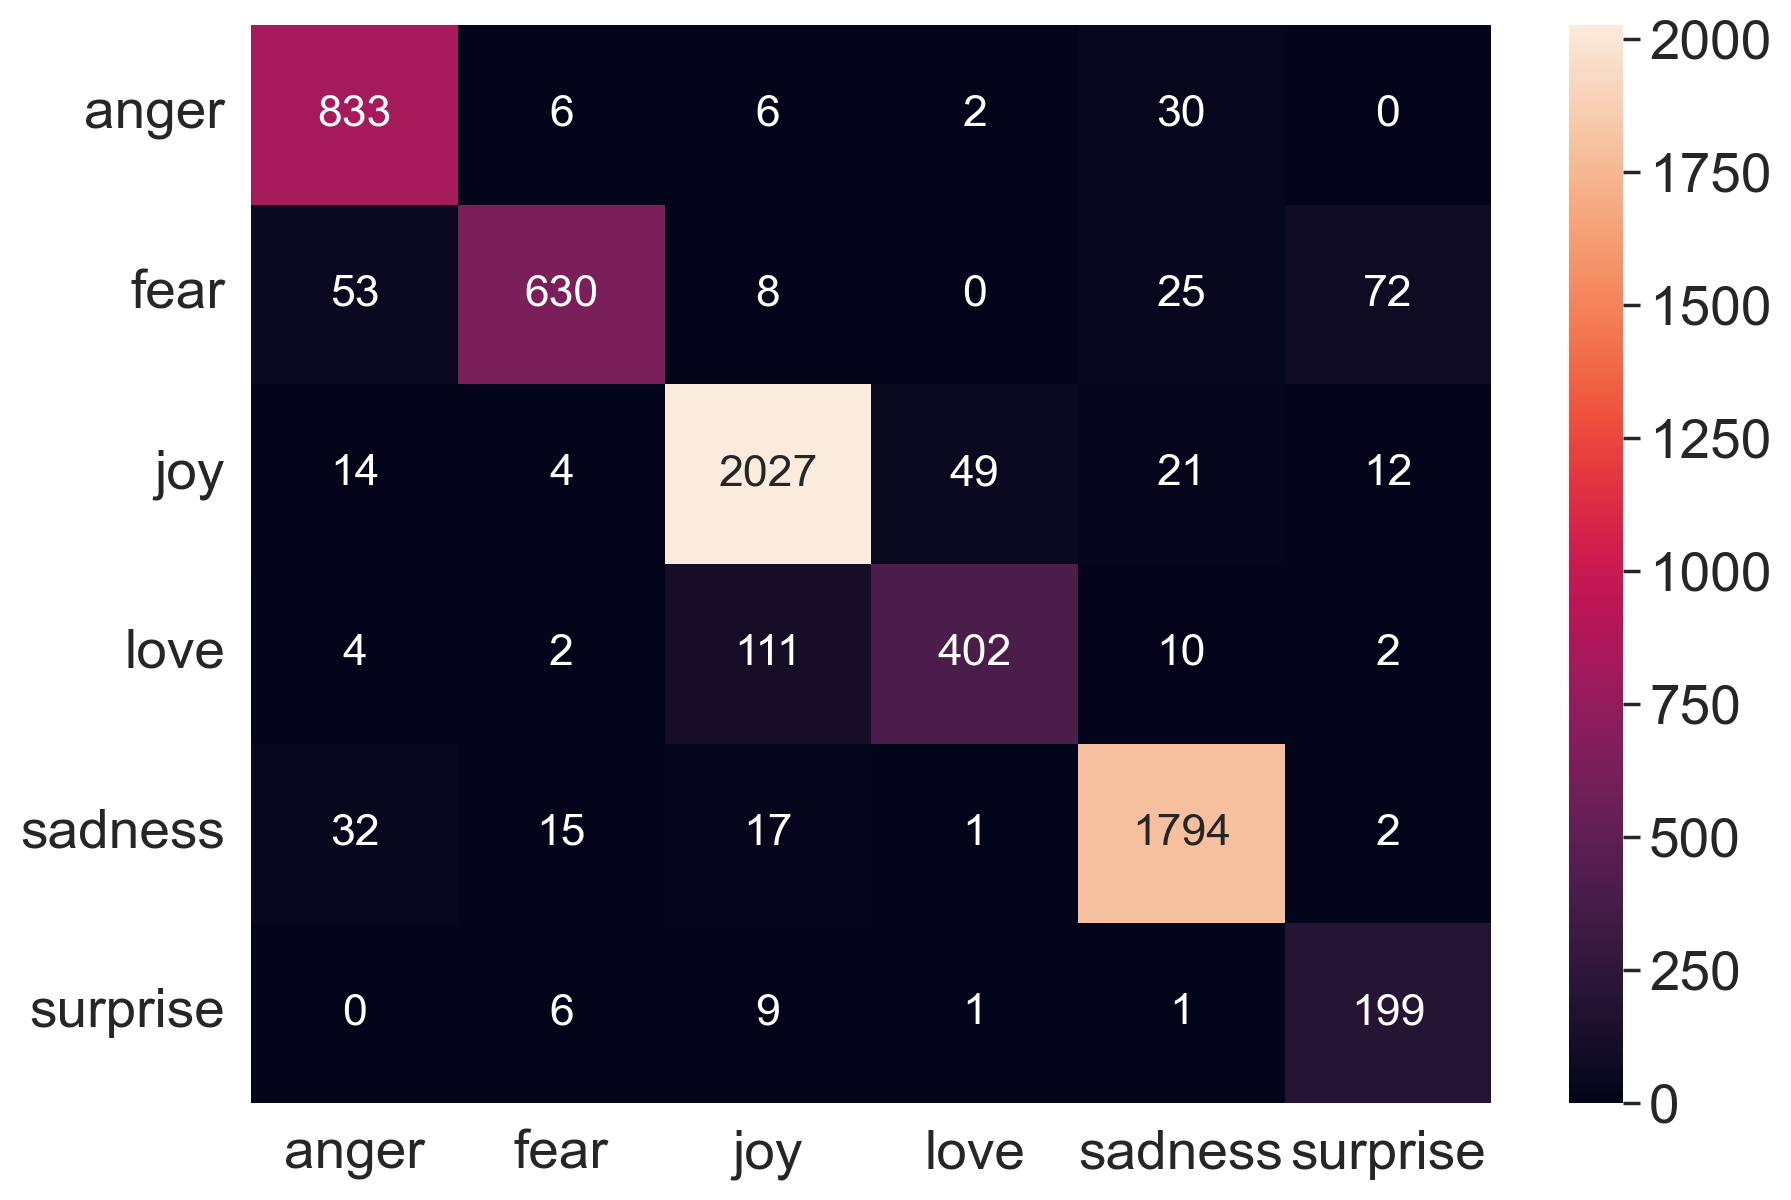

In [18]:
ref=[]
predictions=[]
for batch in test_loader:
    input_ids, attention_mask, targets = batch
    input_ids, attention_mask, targets = input_ids.to(device), attention_mask.to(device), targets.to(device)
    outputs = model(input_ids, attention_mask)
    # outputs = torch.squeeze(outputs)
    targets = targets.squeeze(1).long()
    predicted_labels = torch.argmax(outputs, dim=1)
    ref.extend(targets.cpu().numpy())
    predictions.extend(predicted_labels.cpu().numpy())



cm=confusion_matrix(ref,predictions)


label_names=[]
for key,_ in mapping.items():
    label_names.append(key)

    
#plot confusion matrix

df_cm = pd.DataFrame(cm, label_names,label_names)
plt.figure(figsize = (10,7),dpi=200)
sns.set(font_scale=1.8)  # Increase the font size for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='d') # font size

In [19]:
print(classification_report(ref, predictions,digits=4))

              precision    recall  f1-score   support

           0     0.8900    0.9498    0.9189       877
           1     0.9502    0.7995    0.8684       788
           2     0.9307    0.9530    0.9417      2127
           3     0.8835    0.7571    0.8154       531
           4     0.9537    0.9640    0.9588      1861
           5     0.6934    0.9213    0.7913       216

    accuracy                         0.9195      6400
   macro avg     0.8836    0.8908    0.8824      6400
weighted avg     0.9223    0.9195    0.9190      6400

